In [3]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from objectives import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [4]:
T = 20
K = 3
D = 2

## Model Parameters
num_particles_rws = 30
mcmc_steps = 10
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * K
BATCH_SIZE = 100
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4
CUDA = False
RESTORE = False
PATH_ENC = "stepwise_enc-%drws-%dmcmc-%dsmc-enc-%s" % (num_particles_rws, mcmc_steps, num_particles_smc, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

In [5]:
Ys = np.load('sequences.npy')
As_true = torch.from_numpy(np.load('transitions.npy')).float()
Zs_true = torch.from_numpy(np.load('states.npy')).float()
mu_ks = torch.from_numpy(np.load('means.npy')).float()
cov_ks = torch.from_numpy(np.load('covariances.npy')).float()
Pi = torch.from_numpy(np.load('init.npy')).float()

prior = initial_trans_prior(K)

In [6]:
def initial_trans(prior, K, batch_size):
    As = torch.zeros((batch_size, K, K)).float()
    for k in range(K):
        As[:, k, :] = Dirichlet(prior[k]).sample((batch_size,))
    return As

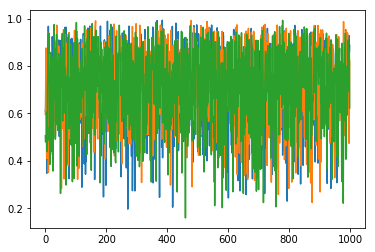

In [7]:
for k in range(K):
    diags = Dirichlet(prior[k]).sample((1000,))[:, k].data.numpy()
    plt.plot(diags)

In [ ]:
for k in range(K):
    diags = Dirichlet(prior[k] * 0.5).sample((1000,))[:, k].data.numpy()
    plt.plot(diags)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior, batch_size):
        As = torch.zeros((batch_size, K, K))
        hidden = self.enc_hidden(obs)
        alphas = F.softmax(self.latent_dir(hidden), -1).view(batch_size, T-1, K*K).sum(1).view(batch_size, K, K) + prior
        for k in range(K):
            As[:, k, :] = Dirichlet(alphas[:, k, :]).sample()
        return alphas, As

In [ ]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()


def ag_sis_debug(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Ys, T, D, K, num_particles_rws, num_particles_smc, batch_size):
    log_increment_weights = torch.zeros((batch_size, num_particles_rws))
    kls = torch.zeros(batch_size).float()
    for l in range(num_particles_rws):
        ## As B * K * K
        As = As_true[:BATCH_SIZE]
        Zs, log_weights, log_normalizers = smc_hmm_batch(Pi, As, mu_ks, cov_ks, Ys, T, D, K, num_particles_smc, batch_size)
        ## Z B * T * K
        Z = smc_resamplings(Zs, log_weights, batch_size)
        ## z_pairs (B * T-1)-by-(2K)
        Z_pairs = flatz(Z, T, K, batch_size)
        variational, As = enc(Z_pairs, alpha_trans_0, batch_size)
        log_qs_phi = log_qs(variational, As)
        log_qs_smc = smc_log_joints(Z, Pi, As, mu_ks, cov_ks, Ys, T, D, K, batch_size)
        log_ps = log_joints(alpha_trans_0, Z, Pi, As, mu_ks, cov_ks, Ys, T, D, K, batch_size).detach()
        log_increment_weights[:, l] = log_ps - log_qs_smc + log_normalizers - log_qs_phi
    for b in range(batch_size):
        posterior = alpha_trans_0 + pairwise(Z[b], T).sum(0)
        kls[b] = kl_dirichlets(posterior, variational[b], K)
    weights_rws = torch.exp(log_increment_weights - logsumexp(log_increment_weights, dim=1).unsqueeze(1)).detach()
    ess = (1. / (weights_rws ** 2 ).sum(1)).mean()
    eubos =  torch.mul(weights_rws, log_increment_weights).sum(-1)
    elbos =  log_increment_weights.mean(-1)
    return eubos.mean(), elbos.mean(), variational, ess, kls.mean()

In [ ]:
EUBOs = []
ELBOs = []
ESSs = []
KLs = []
Divers = []
Grad_Steps = int((Ys.shape[0] / BATCH_SIZE))
for epoch in range(NUM_EPOCHS):
    np.random.shuffle(Ys)
    Ys_shuffled = torch.from_numpy(Ys).float()
    for step in range(Grad_Steps):
        time_start = time.time()
        optimizer.zero_grad()
        batch_data = Ys_shuffled[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        eubo, elbo, variational, ess, kl = ag_sis_debug(enc, alpha_trans_0, Pi, mu_ks, cov_ks, batch_data, T, D, K, num_particles_rws, num_particles_smc, BATCH_SIZE)
#         loss = - elbo
        eubo.backward()
        optimizer.step()
        EUBOs.append(eubo.item())
        ELBOs.append(elbo.item())
        ESSs.append(ess)
        KLs.append(kl)
        time_end = time.time()
        print('epoch : %d, step : %d, EUBO : %f, ELBO : %f, KL : %f (%ds)' % (epoch, step, eubo, elbo, kl, time_end - time_start))

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
x = np.arange(len(a))
ax.plot(x, a, 'k-', label='eubo_true_trans')
ax.plot(x, b, 'k-', label='elbo_true_trans')
ax.legend()
ax.set_xlabel('Gradient Steps', fontsize=18)
ax.set_ylabel('eubos and elbos', fontsize=18)
ax.set_ylim([-120,-70])
plt.savefig(PATH_ENC + 'bounds.png')

    
# plot_kls(KLs, PATH_ENC)

In [ ]:
log_overall_weights_reshape = log_overall_weights.view(-1, num_particles_rws*(mcmc_steps+1))
log_increment_weights_reshape = log_increment_weights.view(-1, num_particles_rws*(mcmc_steps+1))
weights_rws = torch.exp(log_overall_weights_reshape - logsumexp(log_overall_weights_reshape, dim=1).unsqueeze(1)).detach()

ess = (1. / (weights_rws ** 2 ).sum(1)).mean()
eubos =  torch.mul(weights_rws, log_increment_weights_reshape).sum(1)
elbos =  log_increment_weights.sum(-1).mean(-1)

In [ ]:
batch_size = 5
Ys_shuffled = torch.from_numpy(Ys).float()
batch_data = Ys_shuffled[0*batch_size : (0+1)*batch_size]

As = initial_trans(alpha_trans_0, K, batch_size)
Zs, log_weights, log_normalizers = smc_hmm_batch(Pi, As, mu_ks, cov_ks, batch_data, T, D, K, num_particles_smc, batch_size)
## Z B * T * K
Z = smc_resamplings(Zs, log_weights, batch_size)

In [ ]:
Zs_t = Zs_true[:5]
for k in range(5):
    print(torch.abs(Z[k] - Zs_t[k]).sum())

In [ ]:
log_normalizers

In [ ]:
zs2, log_weights2, log_normalizer2 = smc_hmm(Pi, As[3], mu_ks, cov_ks, batch_data[3], T, D, K, num_particles_smc)
z2 = smc_resampling(zs2, log_weights2)

In [ ]:
log_normalizer2

In [ ]:
z2 - Zs_t[3]